# (N)on-(E)uclidean (U)pgrading
---
#### Description of NEU:
The NEU meta-algorithm learns a geometry for the input and (input $\times$ output) spaces by deforming them with a universal class of homeomorphisms + robustifies the involved loss functions to improve generalizability of the new and very flexible model.  
$$
\begin{aligned}
f \mapsto& \, \rho \circ f \circ \phi\\
\mathbb{E}_{\mathbb{P}}[\ell(f(X))] \mapsto & \,\max_{\mathbb{Q}\sim \mathbb{P}}\, \mathbb{E}_{\mathbb{Q}}[\ell(\rho(\phi(X), f\circ \phi(X)))].
\end{aligned}
$$
$\rho=\pi\circ \tilde{\rho}$, and $\tilde{\rho}$ and $\phi$ are "universal homeomorphisms" on $\operatorname{dom}(f)$ and on $\operatorname{dom}(f)\times \operatorname{co-dom}(f)$, respectively.  

---

---

#### Description of regression problem: 
In this notebook we implement the regression problem
$$
\begin{aligned}
y_i =&  \,f(x_i)\delta_i + \epsilon_i, \qquad i=1,\dots,N\\
\epsilon_i \sim &\, \mathcal{N}(0,\sigma),\\
\delta_i\sim &  \,U(1-D,1+D),
\end{aligned}
$$
for some *variance* $\sigma>0$ and *degree of model misspecification level* $0<D<1$.  
The quantity $\epsilon$ can be understood as, classical, additive noise while the quantity $\delta$ represents multiplicative noise.

---

---

### Functions from the paper:
 - 1) $\min\{\exp(\frac{-1}{(1+x)^2}),x+\cos(x)\}$. Reason: Evaluate performance for pasted functions and general badness.
 - 2) $\cos(\exp(-x))$.  Reason: Evaluate performance for non-periodic osculations.
 - 3) $I_{(-\infty,\frac1{2})}$.  Reason: Evaluation performance on a single jump.  
 
 ---

## Initializations:

In [1]:
# Data Structuring
import numpy as np
import pandas as pd


# Pre-Processing
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from scipy.special import expit

# Regression
from sklearn.linear_model import LinearRegression
from scipy import linalg as scila

# Tensorflow
import tensorflow as tf
import keras as K
import keras.backend as Kb
from keras.layers import *
from keras.models import Model
from keras.models import Sequential
from keras import layers
from keras import utils as np_utils
from tensorflow.keras.initializers import RandomUniform
from tensorflow.keras.constraints import NonNeg
from tensorflow.keras.optimizers import Adam

# Operating-System Related
import os
from pathlib import Path

# Visualization
from matplotlib.pyplot import figure

# z_Misc
import time
import math

Using TensorFlow backend.


## Check/Make Paths

In [2]:
Path('./outputs/models/').mkdir(parents=True, exist_ok=True)
Path('./outputs/models/Benchmarks/').mkdir(parents=True, exist_ok=True)
Path('./outputs/models/Benchmarks/Invertible_Networks/GLd_Net/').mkdir(parents=True, exist_ok=True)
Path('./outputs/models/Benchmarks/Invertible_Networks/Ed_Net/').mkdir(parents=True, exist_ok=True)
Path('./outputs/models/Benchmarks/Linear_Regression/').mkdir(parents=True, exist_ok=True)
Path('./outputs/models/NEU/').mkdir(parents=True, exist_ok=True)
Path('./outputs/models/NEU/Greedy_Initializations/').mkdir(parents=True, exist_ok=True)
Path('./outputs/models/NEU/Greedy_Initializations/Base_Regressor/').mkdir(parents=True, exist_ok=True)
Path('./outputs/tables/').mkdir(parents=True, exist_ok=True)
Path('./outputs/results/').mkdir(parents=True, exist_ok=True)
Path('./inputs/data/').mkdir(parents=True, exist_ok=True)

## Initialize Internal Variables/(Hyper)parameter(s)

In [3]:
#---------------------------------#
# General Formatting Parameter(s) #
#---------------------------------#
d = 1 # Dimension of X
D = 1 # Dimension of Y

#------------------------------------#
# Training/Optimization Parameter(s) #
#------------------------------------#
# Robustness Parameter
robustness_parameter = .1
# Training meta-parameters
Pre_Epochs = 50
Full_Epochs = 600

#---------------------------#
# Architecture Parameter(s) #
#---------------------------#
# 1) Base Model
#---------------#
Initial_Depth = 2
Initial_Height = 50
# 2) Feature Map
#---------------#
Feature_map_depth = 40
Feature_map_height = 5
# 3) Readout Map
#---------------#
# Reconfiguration Parameters
N_Reconfigurations = 50
# Depth & Height Per Reconfiguration
Depth_per_reconfig = 30
Height_per_reconfig = 5

#-------------------#
# Data Parameter(s) #
#-------------------#
# Test-set meta-parameters
Train_step_proportion = .5 # (i.e.: ratio of train to test-set sizes)
Extrapolation_size = .25 # (i.e.: size of test-train set domain (diameter/2))
# Train Data meta-parameters
N_data = 10**3 # (i.e.: N)
# Noise Parameters
noise_level = .5 # (i.e.: ε_i)
Distortion = .7 # (i.e.: δ_i)
# Unknown Function:
def unknown_f(x):
    return .1*x + .1*(x**4) + x*np.exp(-np.abs(x)) + np.sin(4*x + 3*x**2) + np.cos(7*(x**2))+ (x % .5)

### Run External/Auxiliary Notebooks

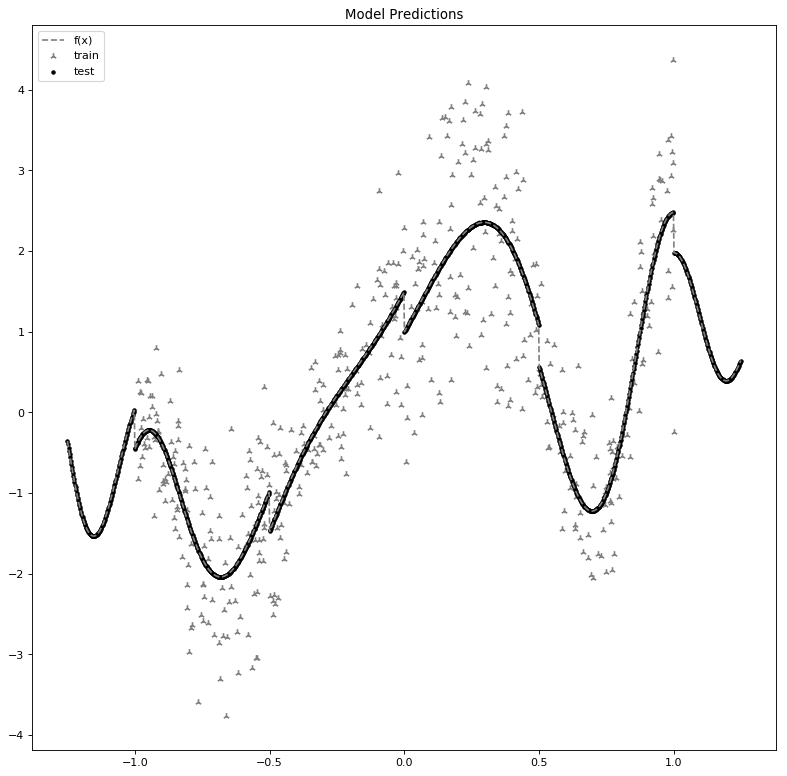

In [4]:
#------------------------#
# Run External Notebooks #
#------------------------#
# Generate Data
%run Data_Generator.ipynb
# Import Custom Layer(s)
%run Special_Layers_Homeomorphic.ipynb
# Import Utility for NEU
%run NEU_Util.ipynb
# Import Benchmarks
%run Benchmarks_Util.ipynb

#### Prepare data for NEU

## 1) Get Basic Regression Models
 1. Get Base regression model (benchmark),
 2. Get Base regression model for NEU.

## Get basic regression model - Benchmark

In [5]:
if os.path.exists('./outputs/models/Benchmarks/Linear_Regression/saved_model.pb'):
    #------------------#
    # Load Readout Map #
    #------------------#
    print('Benchmark model - already exists: Loading...')
    regression_Benchmark = tf.keras.models.load_model("./outputs/models/Benchmarks/Linear_Regression/")
    print('Benchmark model - already exists: Loaded.')
else:
    print('Pre-trained benchmark model does not exist: Training.')
    regression_Benchmark = def_model_Regression(data_x,
                                                data_y,
                                                Pre_Epochs_in=Full_Epochs,
                                                height=(N_Reconfigurations*Height_per_reconfig),
                                                depth=Initial_Depth,
                                                learning_rate=0.01)
    
    #-----------------#
    # Save Full-Model #
    #-----------------#
    print('Benchmark-Model: Saving')
    regression_Benchmark.save("./outputs/models/Benchmarks/Linear_Regression/")
    print('Benchmark-Model: Saved')
    
# Generate Predictions #
#----------------------#
predictions_OLS_Benchmark =  regression_Benchmark.predict(data_x)
predictions_OLS_Benchmark = predictions_OLS_Benchmark.reshape(-1,)
predictions_OLS_Benchmark_test =  regression_Benchmark.predict(data_x_test)
predictions_OLS_Benchmark_test = predictions_OLS_Benchmark_test.reshape(-1,)

Pre-trained benchmark model does not exist: Training.
Epoch 1/600
16/16 [==============================] - 0s 3ms/step - loss: 1.1929 - mse: 2.2649 - mae: 1.1929 - mape: 238.4373
Epoch 2/600
16/16 [==============================] - 0s 2ms/step - loss: 1.0334 - mse: 1.6942 - mae: 1.0334 - mape: 317.8565
Epoch 3/600
16/16 [==============================] - 0s 4ms/step - loss: 0.9980 - mse: 1.6130 - mae: 0.9980 - mape: 228.1463
Epoch 4/600
16/16 [==============================] - 0s 3ms/step - loss: 1.0240 - mse: 1.7386 - mae: 1.0240 - mape: 234.0745
Epoch 5/600
16/16 [==============================] - 0s 2ms/step - loss: 0.9738 - mse: 1.5681 - mae: 0.9738 - mape: 197.5331
Epoch 6/600
16/16 [==============================] - 0s 3ms/step - loss: 0.9476 - mse: 1.3952 - mae: 0.9476 - mape: 207.0242
Epoch 7/600
16/16 [==============================] - 0s 3ms/step - loss: 0.9056 - mse: 1.3024 - mae: 0.9056 - mape: 186.2266
Epoch 8/600
16/16 [==============================] - 0s 4ms/step - loss

16/16 [==============================] - 0s 2ms/step - loss: 0.7108 - mse: 0.8165 - mae: 0.7108 - mape: 230.8666
Epoch 66/600
16/16 [==============================] - 0s 2ms/step - loss: 0.6833 - mse: 0.7518 - mae: 0.6833 - mape: 202.2954
Epoch 67/600
16/16 [==============================] - 0s 2ms/step - loss: 0.6690 - mse: 0.7383 - mae: 0.6690 - mape: 197.9574
Epoch 68/600
16/16 [==============================] - 0s 2ms/step - loss: 0.6734 - mse: 0.7132 - mae: 0.6734 - mape: 237.5185
Epoch 69/600
16/16 [==============================] - 0s 2ms/step - loss: 0.6908 - mse: 0.7604 - mae: 0.6908 - mape: 226.2598
Epoch 70/600
16/16 [==============================] - 0s 2ms/step - loss: 0.6800 - mse: 0.7434 - mae: 0.6800 - mape: 193.1539
Epoch 71/600
16/16 [==============================] - 0s 2ms/step - loss: 0.6862 - mse: 0.7500 - mae: 0.6862 - mape: 233.9851
Epoch 72/600
16/16 [==============================] - 0s 2ms/step - loss: 0.6970 - mse: 0.7872 - mae: 0.6970 - mape: 199.5510
Epoch

16/16 [==============================] - 0s 1ms/step - loss: 0.6595 - mse: 0.6773 - mae: 0.6595 - mape: 175.9933
Epoch 130/600
16/16 [==============================] - 0s 2ms/step - loss: 0.6707 - mse: 0.7142 - mae: 0.6707 - mape: 218.4762
Epoch 131/600
16/16 [==============================] - 0s 2ms/step - loss: 0.6502 - mse: 0.6855 - mae: 0.6502 - mape: 242.8917
Epoch 132/600
16/16 [==============================] - 0s 1ms/step - loss: 0.6523 - mse: 0.6943 - mae: 0.6523 - mape: 208.2660
Epoch 133/600
16/16 [==============================] - 0s 1ms/step - loss: 0.6529 - mse: 0.6941 - mae: 0.6529 - mape: 204.5714
Epoch 134/600
16/16 [==============================] - 0s 2ms/step - loss: 0.6589 - mse: 0.6914 - mae: 0.6589 - mape: 192.8425
Epoch 135/600
16/16 [==============================] - 0s 3ms/step - loss: 0.6753 - mse: 0.7370 - mae: 0.6753 - mape: 182.0402
Epoch 136/600
16/16 [==============================] - 0s 2ms/step - loss: 0.6613 - mse: 0.6952 - mae: 0.6613 - mape: 188.358

16/16 [==============================] - 0s 2ms/step - loss: 0.6761 - mse: 0.7633 - mae: 0.6761 - mape: 225.7277
Epoch 194/600
16/16 [==============================] - 0s 2ms/step - loss: 0.7050 - mse: 0.8106 - mae: 0.7050 - mape: 188.8636
Epoch 195/600
16/16 [==============================] - 0s 2ms/step - loss: 0.6630 - mse: 0.7049 - mae: 0.6630 - mape: 210.2089
Epoch 196/600
16/16 [==============================] - 0s 2ms/step - loss: 0.6587 - mse: 0.7034 - mae: 0.6587 - mape: 208.8246
Epoch 197/600
16/16 [==============================] - 0s 2ms/step - loss: 0.6466 - mse: 0.6704 - mae: 0.6466 - mape: 206.2512
Epoch 198/600
16/16 [==============================] - 0s 2ms/step - loss: 0.6506 - mse: 0.6835 - mae: 0.6506 - mape: 222.2831
Epoch 199/600
16/16 [==============================] - 0s 2ms/step - loss: 0.6569 - mse: 0.6885 - mae: 0.6569 - mape: 198.4078
Epoch 200/600
16/16 [==============================] - 0s 1ms/step - loss: 0.6560 - mse: 0.6824 - mae: 0.6560 - mape: 234.765

16/16 [==============================] - 0s 2ms/step - loss: 0.6696 - mse: 0.7183 - mae: 0.6696 - mape: 185.9998
Epoch 258/600
16/16 [==============================] - 0s 2ms/step - loss: 0.6508 - mse: 0.6643 - mae: 0.6508 - mape: 225.0658
Epoch 259/600
16/16 [==============================] - 0s 2ms/step - loss: 0.6512 - mse: 0.6666 - mae: 0.6512 - mape: 181.3248
Epoch 260/600
16/16 [==============================] - 0s 2ms/step - loss: 0.6546 - mse: 0.6830 - mae: 0.6546 - mape: 218.4808
Epoch 261/600
16/16 [==============================] - 0s 1ms/step - loss: 0.6383 - mse: 0.6703 - mae: 0.6383 - mape: 219.9061
Epoch 262/600
16/16 [==============================] - 0s 1ms/step - loss: 0.6431 - mse: 0.6681 - mae: 0.6431 - mape: 205.9405
Epoch 263/600
16/16 [==============================] - 0s 2ms/step - loss: 0.6491 - mse: 0.6895 - mae: 0.6491 - mape: 204.8977
Epoch 264/600
16/16 [==============================] - 0s 2ms/step - loss: 0.6416 - mse: 0.6656 - mae: 0.6416 - mape: 229.884

16/16 [==============================] - 0s 2ms/step - loss: 0.6509 - mse: 0.6829 - mae: 0.6509 - mape: 231.2669
Epoch 322/600
16/16 [==============================] - 0s 1ms/step - loss: 0.6558 - mse: 0.6901 - mae: 0.6558 - mape: 209.4494
Epoch 323/600
16/16 [==============================] - 0s 1ms/step - loss: 0.6353 - mse: 0.6569 - mae: 0.6353 - mape: 212.3673
Epoch 324/600
16/16 [==============================] - 0s 2ms/step - loss: 0.6415 - mse: 0.6663 - mae: 0.6415 - mape: 216.8199
Epoch 325/600
16/16 [==============================] - 0s 2ms/step - loss: 0.6385 - mse: 0.6578 - mae: 0.6385 - mape: 200.8738
Epoch 326/600
16/16 [==============================] - 0s 2ms/step - loss: 0.6344 - mse: 0.6599 - mae: 0.6344 - mape: 200.9904
Epoch 327/600
16/16 [==============================] - 0s 1ms/step - loss: 0.6455 - mse: 0.6702 - mae: 0.6455 - mape: 176.5400
Epoch 328/600
16/16 [==============================] - 0s 1ms/step - loss: 0.6416 - mse: 0.6876 - mae: 0.6416 - mape: 207.102

16/16 [==============================] - 0s 2ms/step - loss: 0.6428 - mse: 0.6538 - mae: 0.6428 - mape: 177.7937
Epoch 386/600
16/16 [==============================] - 0s 2ms/step - loss: 0.6372 - mse: 0.6643 - mae: 0.6372 - mape: 227.5122
Epoch 387/600
16/16 [==============================] - 0s 2ms/step - loss: 0.6463 - mse: 0.6717 - mae: 0.6463 - mape: 201.4114
Epoch 388/600
16/16 [==============================] - 0s 2ms/step - loss: 0.6484 - mse: 0.6909 - mae: 0.6484 - mape: 237.9457
Epoch 389/600
16/16 [==============================] - 0s 1ms/step - loss: 0.6508 - mse: 0.6699 - mae: 0.6508 - mape: 194.8631
Epoch 390/600
16/16 [==============================] - 0s 2ms/step - loss: 0.6267 - mse: 0.6503 - mae: 0.6267 - mape: 210.5623
Epoch 391/600
16/16 [==============================] - 0s 2ms/step - loss: 0.6413 - mse: 0.6607 - mae: 0.6413 - mape: 185.3522
Epoch 392/600
16/16 [==============================] - 0s 2ms/step - loss: 0.6543 - mse: 0.6929 - mae: 0.6543 - mape: 210.573

16/16 [==============================] - 0s 2ms/step - loss: 0.6412 - mse: 0.6652 - mae: 0.6412 - mape: 216.4061
Epoch 450/600
16/16 [==============================] - 0s 2ms/step - loss: 0.6400 - mse: 0.6597 - mae: 0.6400 - mape: 189.3128
Epoch 451/600
16/16 [==============================] - 0s 2ms/step - loss: 0.6389 - mse: 0.6702 - mae: 0.6389 - mape: 228.6250
Epoch 452/600
16/16 [==============================] - 0s 2ms/step - loss: 0.6407 - mse: 0.6511 - mae: 0.6407 - mape: 199.9392
Epoch 453/600
16/16 [==============================] - 0s 2ms/step - loss: 0.6524 - mse: 0.7081 - mae: 0.6524 - mape: 213.9723
Epoch 454/600
16/16 [==============================] - 0s 2ms/step - loss: 0.6339 - mse: 0.6533 - mae: 0.6339 - mape: 192.6848
Epoch 455/600
16/16 [==============================] - 0s 2ms/step - loss: 0.6444 - mse: 0.6732 - mae: 0.6444 - mape: 201.4242
Epoch 456/600
16/16 [==============================] - 0s 2ms/step - loss: 0.6398 - mse: 0.6852 - mae: 0.6398 - mape: 231.738

16/16 [==============================] - 0s 2ms/step - loss: 0.6440 - mse: 0.6798 - mae: 0.6440 - mape: 198.3852
Epoch 514/600
16/16 [==============================] - 0s 2ms/step - loss: 0.6867 - mse: 0.7792 - mae: 0.6867 - mape: 201.5660
Epoch 515/600
16/16 [==============================] - 0s 2ms/step - loss: 0.6291 - mse: 0.6585 - mae: 0.6291 - mape: 206.3934
Epoch 516/600
16/16 [==============================] - 0s 3ms/step - loss: 0.6578 - mse: 0.7064 - mae: 0.6578 - mape: 199.1399
Epoch 517/600
16/16 [==============================] - 0s 3ms/step - loss: 0.6445 - mse: 0.6594 - mae: 0.6445 - mape: 206.2936
Epoch 518/600
16/16 [==============================] - 0s 2ms/step - loss: 0.6348 - mse: 0.6607 - mae: 0.6348 - mape: 199.0950
Epoch 519/600
16/16 [==============================] - 0s 2ms/step - loss: 0.6443 - mse: 0.6677 - mae: 0.6443 - mape: 208.6127
Epoch 520/600
16/16 [==============================] - 0s 2ms/step - loss: 0.6432 - mse: 0.6657 - mae: 0.6432 - mape: 189.839

16/16 [==============================] - 0s 2ms/step - loss: 0.6439 - mse: 0.6815 - mae: 0.6439 - mape: 203.3168
Epoch 578/600
16/16 [==============================] - 0s 2ms/step - loss: 0.6413 - mse: 0.6735 - mae: 0.6413 - mape: 222.1172
Epoch 579/600
16/16 [==============================] - 0s 2ms/step - loss: 0.6401 - mse: 0.6703 - mae: 0.6401 - mape: 205.9644
Epoch 580/600
16/16 [==============================] - 0s 2ms/step - loss: 0.6352 - mse: 0.6552 - mae: 0.6352 - mape: 181.4146
Epoch 581/600
16/16 [==============================] - 0s 2ms/step - loss: 0.6414 - mse: 0.6765 - mae: 0.6414 - mape: 184.5870
Epoch 582/600
16/16 [==============================] - 0s 2ms/step - loss: 0.6451 - mse: 0.6788 - mae: 0.6451 - mape: 185.4764
Epoch 583/600
16/16 [==============================] - 0s 2ms/step - loss: 0.6478 - mse: 0.7036 - mae: 0.6478 - mape: 209.1817
Epoch 584/600
16/16 [==============================] - 0s 2ms/step - loss: 0.6683 - mse: 0.7195 - mae: 0.6683 - mape: 181.998

## 1+2) Get base regression model for NEU + Learn optimal feature map

In [6]:
if False:#os.path.exists('./outputs/models/Benchmarks/Greedy_Initializations/Base_Regressor/saved_model.pb'):
    #------------------#
    # Load Readout Map #
    #------------------#
    print('Base Regressor model - already exists: Loading...')
    regression_basic = tf.keras.models.load_model('./outputs/models/Benchmarks/Greedy_Initializations/Base_Regressor/', custom_objects={'Robust_MSE': Robust_MSE})
    print('Base Regressor model - already exists: Loaded.')
else:
    print('Pre-trained benchmark model does not exist: Training.')
    regression_basic = get_base_model_Regression(data_x, 
                                             data_NEU, 
                                             Pre_Epochs_in=Full_Epochs, 
                                             height=Initial_Height, 
                                             depth=Initial_Depth,
                                             feature_map_depth=Feature_map_depth,
                                             feature_map_height=Feature_map_height,
                                             learning_rate=0.01)
    
    
    #-----------------#
    # Save Full-Model #
    #-----------------#
    print('Base Regressor-Model: Saving')
    regression_basic.save("./outputs/models/Benchmarks/Greedy_Initializations/Base_Regressor/")
    print('Base Regressor-Model: Saved')
    
# Generate Predictions #
#----------------------#
predictions_OLS = regression_basic.predict(data_x)
predictions_OLS = predictions_OLS.reshape(-1,)
predictions_OLS_test = regression_basic.predict(data_x_test)

Pre-trained benchmark model does not exist: Training.
Epoch 1/600
16/16 - 0s - loss: 67.4705 - mse: 1.2308 - mae: 0.6361 - mape: 101.9539
Epoch 2/600
16/16 - 0s - loss: 66.7372 - mse: 0.9240 - mae: 0.5384 - mape: 155.8342
Epoch 3/600
16/16 - 0s - loss: 66.7953 - mse: 0.9535 - mae: 0.5468 - mape: 110.5494
Epoch 4/600
16/16 - 0s - loss: 66.5305 - mse: 0.8329 - mae: 0.5109 - mape: 138.8219
Epoch 5/600
16/16 - 0s - loss: 66.5728 - mse: 0.8640 - mae: 0.5137 - mape: 139.0957
Epoch 6/600
16/16 - 0s - loss: 66.4430 - mse: 0.7902 - mae: 0.4978 - mape: 146.5991
Epoch 7/600
16/16 - 0s - loss: 66.4107 - mse: 0.7834 - mae: 0.4944 - mape: 129.1455
Epoch 8/600
16/16 - 0s - loss: 66.4378 - mse: 0.7881 - mae: 0.4966 - mape: 122.1645
Epoch 9/600
16/16 - 0s - loss: 66.2138 - mse: 0.6997 - mae: 0.4653 - mape: 129.0194
Epoch 10/600
16/16 - 0s - loss: 66.1115 - mse: 0.6729 - mae: 0.4508 - mape: 116.6332
Epoch 11/600
16/16 - 0s - loss: 66.0791 - mse: 0.6649 - mae: 0.4469 - mape: 108.2031
Epoch 12/600
16/16 -

Epoch 98/600
16/16 - 0s - loss: 65.2466 - mse: 0.3531 - mae: 0.3318 - mape: 117.1169
Epoch 99/600
16/16 - 0s - loss: 65.4166 - mse: 0.3951 - mae: 0.3551 - mape: 110.1887
Epoch 100/600
16/16 - 0s - loss: 65.2964 - mse: 0.3712 - mae: 0.3384 - mape: 102.3946
Epoch 101/600
16/16 - 0s - loss: 65.3894 - mse: 0.4009 - mae: 0.3523 - mape: 116.1845
Epoch 102/600
16/16 - 0s - loss: 65.2211 - mse: 0.3451 - mae: 0.3276 - mape: 102.1404
Epoch 103/600
16/16 - 0s - loss: 65.2731 - mse: 0.3647 - mae: 0.3347 - mape: 92.4046
Epoch 104/600
16/16 - 0s - loss: 65.2690 - mse: 0.3654 - mae: 0.3340 - mape: 93.5684
Epoch 105/600
16/16 - 0s - loss: 65.2420 - mse: 0.3508 - mae: 0.3308 - mape: 105.4135
Epoch 106/600
16/16 - 0s - loss: 65.2273 - mse: 0.3442 - mae: 0.3290 - mape: 95.9935
Epoch 107/600
16/16 - 0s - loss: 65.2108 - mse: 0.3418 - mae: 0.3264 - mape: 98.6270
Epoch 108/600
16/16 - 0s - loss: 65.2658 - mse: 0.3555 - mae: 0.3340 - mape: 125.6151
Epoch 109/600
16/16 - 0s - loss: 65.2955 - mse: 0.3677 - mae

Epoch 194/600
16/16 - 0s - loss: 65.3407 - mse: 0.3785 - mae: 0.3433 - mape: 98.0922
Epoch 195/600
16/16 - 0s - loss: 65.2906 - mse: 0.3625 - mae: 0.3371 - mape: 113.1597
Epoch 196/600
16/16 - 0s - loss: 65.2912 - mse: 0.3626 - mae: 0.3386 - mape: 100.8193
Epoch 197/600
16/16 - 0s - loss: 65.2834 - mse: 0.3491 - mae: 0.3376 - mape: 104.4956
Epoch 198/600
16/16 - 0s - loss: 65.2046 - mse: 0.3421 - mae: 0.3257 - mape: 106.8569
Epoch 199/600
16/16 - 0s - loss: 65.2806 - mse: 0.3539 - mae: 0.3356 - mape: 100.5832
Epoch 200/600
16/16 - 0s - loss: 65.2231 - mse: 0.3377 - mae: 0.3288 - mape: 114.6675
Epoch 201/600
16/16 - 0s - loss: 65.2121 - mse: 0.3417 - mae: 0.3267 - mape: 118.4112
Epoch 202/600
16/16 - 0s - loss: 65.2826 - mse: 0.3660 - mae: 0.3348 - mape: 110.9708
Epoch 203/600
16/16 - 0s - loss: 65.2426 - mse: 0.3439 - mae: 0.3317 - mape: 113.9165
Epoch 204/600
16/16 - 0s - loss: 65.2344 - mse: 0.3501 - mae: 0.3291 - mape: 114.3306
Epoch 205/600
16/16 - 0s - loss: 65.2056 - mse: 0.3447 

Epoch 290/600
16/16 - 0s - loss: 65.2264 - mse: 0.3480 - mae: 0.3317 - mape: 99.8898
Epoch 291/600
16/16 - 0s - loss: 65.2600 - mse: 0.3500 - mae: 0.3335 - mape: 103.1725
Epoch 292/600
16/16 - 0s - loss: 65.2838 - mse: 0.3543 - mae: 0.3362 - mape: 98.3123
Epoch 293/600
16/16 - 0s - loss: 65.2312 - mse: 0.3463 - mae: 0.3319 - mape: 126.8175
Epoch 294/600
16/16 - 0s - loss: 65.2294 - mse: 0.3389 - mae: 0.3284 - mape: 100.5302
Epoch 295/600
16/16 - 0s - loss: 65.2947 - mse: 0.3609 - mae: 0.3392 - mape: 106.9821
Epoch 296/600
16/16 - 0s - loss: 65.2206 - mse: 0.3409 - mae: 0.3272 - mape: 99.1950
Epoch 297/600
16/16 - 0s - loss: 65.2064 - mse: 0.3394 - mae: 0.3251 - mape: 93.4336
Epoch 298/600
16/16 - 0s - loss: 65.2204 - mse: 0.3460 - mae: 0.3271 - mape: 78.0188
Epoch 299/600
16/16 - 0s - loss: 65.2638 - mse: 0.3529 - mae: 0.3342 - mape: 98.6155
Epoch 300/600
16/16 - 0s - loss: 65.2318 - mse: 0.3543 - mae: 0.3283 - mape: 117.3513
Epoch 301/600
16/16 - 0s - loss: 65.2565 - mse: 0.3604 - mae

Epoch 386/600
16/16 - 0s - loss: 65.1894 - mse: 0.3399 - mae: 0.3225 - mape: 110.7207
Epoch 387/600
16/16 - 0s - loss: 65.1596 - mse: 0.3266 - mae: 0.3207 - mape: 108.8901
Epoch 388/600
16/16 - 0s - loss: 65.2164 - mse: 0.3494 - mae: 0.3282 - mape: 114.7332
Epoch 389/600
16/16 - 0s - loss: 65.2008 - mse: 0.3355 - mae: 0.3263 - mape: 110.7670
Epoch 390/600
16/16 - 0s - loss: 65.1853 - mse: 0.3342 - mae: 0.3226 - mape: 116.3859
Epoch 391/600
16/16 - 0s - loss: 65.1402 - mse: 0.3281 - mae: 0.3144 - mape: 105.1761
Epoch 392/600
16/16 - 0s - loss: 65.2749 - mse: 0.3627 - mae: 0.3354 - mape: 113.8477
Epoch 393/600
16/16 - 0s - loss: 65.2345 - mse: 0.3454 - mae: 0.3300 - mape: 105.6692
Epoch 394/600
16/16 - 0s - loss: 65.2076 - mse: 0.3537 - mae: 0.3260 - mape: 101.6965
Epoch 395/600
16/16 - 0s - loss: 65.2574 - mse: 0.3536 - mae: 0.3340 - mape: 110.4850
Epoch 396/600
16/16 - 0s - loss: 65.2257 - mse: 0.3524 - mae: 0.3293 - mape: 112.2098
Epoch 397/600
16/16 - 0s - loss: 65.2409 - mse: 0.3489

Epoch 482/600
16/16 - 0s - loss: 65.1683 - mse: 0.3336 - mae: 0.3198 - mape: 100.5708
Epoch 483/600
16/16 - 0s - loss: 65.2360 - mse: 0.3479 - mae: 0.3298 - mape: 116.2267
Epoch 484/600
16/16 - 0s - loss: 65.2208 - mse: 0.3400 - mae: 0.3278 - mape: 88.4620
Epoch 485/600
16/16 - 0s - loss: 65.2190 - mse: 0.3542 - mae: 0.3302 - mape: 117.1569
Epoch 486/600
16/16 - 0s - loss: 65.2963 - mse: 0.3564 - mae: 0.3401 - mape: 108.4023
Epoch 487/600
16/16 - 0s - loss: 65.2676 - mse: 0.3585 - mae: 0.3355 - mape: 93.4808
Epoch 488/600
16/16 - 0s - loss: 65.2188 - mse: 0.3415 - mae: 0.3261 - mape: 102.4714
Epoch 489/600
16/16 - 0s - loss: 65.2138 - mse: 0.3474 - mae: 0.3291 - mape: 105.2004
Epoch 490/600
16/16 - 0s - loss: 65.2007 - mse: 0.3412 - mae: 0.3261 - mape: 102.8325
Epoch 491/600
16/16 - 0s - loss: 65.2095 - mse: 0.3397 - mae: 0.3274 - mape: 106.2901
Epoch 492/600
16/16 - 0s - loss: 65.2875 - mse: 0.3647 - mae: 0.3383 - mape: 113.7133
Epoch 493/600
16/16 - 0s - loss: 65.3249 - mse: 0.3769 -

Epoch 578/600
16/16 - 0s - loss: 65.2204 - mse: 0.3470 - mae: 0.3273 - mape: 107.1117
Epoch 579/600
16/16 - 0s - loss: 65.2096 - mse: 0.3398 - mae: 0.3262 - mape: 113.8796
Epoch 580/600
16/16 - 0s - loss: 65.2446 - mse: 0.3503 - mae: 0.3312 - mape: 86.7549
Epoch 581/600
16/16 - 0s - loss: 65.2029 - mse: 0.3354 - mae: 0.3252 - mape: 102.7516
Epoch 582/600
16/16 - 0s - loss: 65.3127 - mse: 0.3718 - mae: 0.3400 - mape: 98.4489
Epoch 583/600
16/16 - 0s - loss: 65.2113 - mse: 0.3462 - mae: 0.3277 - mape: 103.9285
Epoch 584/600
16/16 - 0s - loss: 65.2093 - mse: 0.3441 - mae: 0.3253 - mape: 86.7836
Epoch 585/600
16/16 - 0s - loss: 65.1788 - mse: 0.3407 - mae: 0.3219 - mape: 107.2078
Epoch 586/600
16/16 - 0s - loss: 65.2296 - mse: 0.3464 - mae: 0.3300 - mape: 107.5611
Epoch 587/600
16/16 - 0s - loss: 65.2123 - mse: 0.3522 - mae: 0.3266 - mape: 112.3506
Epoch 588/600
16/16 - 0s - loss: 65.1761 - mse: 0.3368 - mae: 0.3216 - mape: 105.6303
Epoch 589/600
16/16 - 0s - loss: 65.3005 - mse: 0.3720 - 

### Generate Plots - Visualization

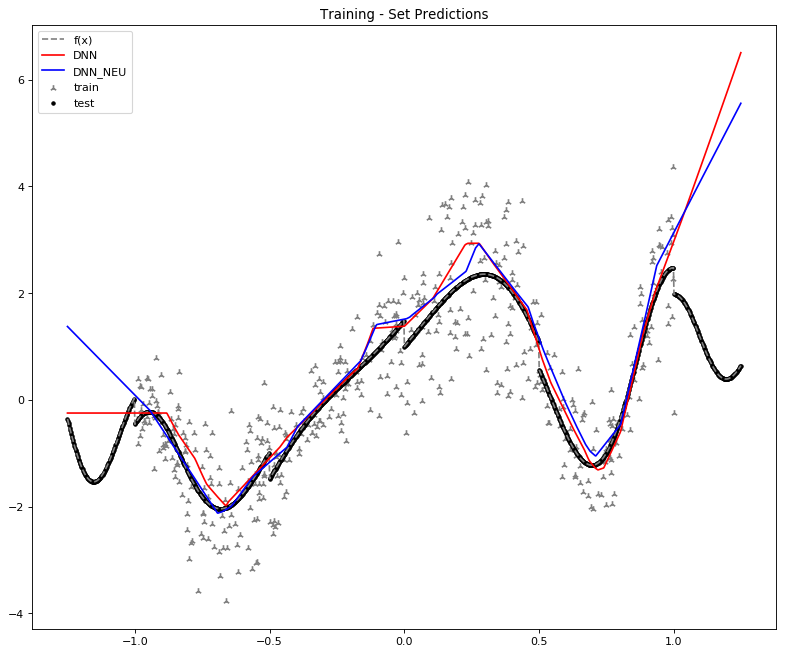

In [7]:
# Initialize Plot #
#-----------------#
plt.figure(num=None, figsize=(12, 10), dpi=80, facecolor='w', edgecolor='k')

# Generate Plots #
#----------------#

# Plot Signal
plt.plot(np.array(data_x_test).reshape(-1,),data_y_test,color='gray',label='f(x)',linestyle='--')
# Plot Data
plt.scatter(np.array(data_x).reshape(-1,),data_y,color='gray',label='train', marker = '2')
plt.scatter(np.array(data_x_test).reshape(-1,),data_y_test,color='black',label='test', marker = '.')


# Plot Benchmark(s)
plt.plot(np.array(data_x_test).reshape(-1,),(predictions_OLS_Benchmark_test.reshape(-1,)), color = 'red', label='DNN')
# Plot NEU Regressors
plt.plot(np.array(data_x_test).reshape(-1,),predictions_OLS_test[:,1], color = 'blue',label='DNN_NEU')

# Format Plot #
#-------------#
plt.legend(loc="upper left")
plt.title("Training - Set Predictions")
plt.show()

## 3) Readout
 1. Get Base Model,
 2. Greedy Layer-Wise Initialization,
 3. Robust SGD on entire structure.
 
We train NEU-OLS, by unfreezing the greedily initialized layers, as per [this paper](https://papers.nips.cc/paper/3048-greedy-layer-wise-training-of-deep-networks.pdf), and using "robust"-SGD on the whole structure.

In [8]:
#----------------------------------#
# Greedy Layer-Wise Initialization #
#----------------------------------#
if os.path.exists("./outputs/models/NEU/Greedy_Initializations/saved_model.pb"):
    #------------------#
    # Load Readout Map #
    #------------------#
    print('Pre-trained readout-map already exists: Loading.')
    NEU_OLS_Greedy_init = tf.keras.models.load_model("./outputs/models/NEU/Greedy_Initializations/")
    print('Saved pre-trained readout-map: Loaded.')
    #-----------------#
    # Load Full-Model #
    #-----------------#
    print('Full-model already exists: Loading.')
    NEU_OLS = tf.keras.models.load_model("./outputs/models/NEU/", custom_objects={'Robust_MSE': Robust_MSE})
    print('Full-Model: Loaded')
else:
    
    #------------------------------------------------------------------------------------------------------#
    #------------------------------------------------------------------------------------------------------#
    #------------------------------------------------------------------------------------------------------#
    #                                          Pre-Trained Model                                           #
    #------------------------------------------------------------------------------------------------------#
    #------------------------------------------------------------------------------------------------------#
    #------------------------------------------------------------------------------------------------------#
    
    print('Pre-trained model does not exist: Training.')
    # Greedy Initialization
    model = regression_basic
    NEU_OLS_Greedy_init = model
    for i in range(N_Reconfigurations):
        # Update Model
        NEU_OLS_Greedy_init_temp = add_reconfiguration_unit_greedily(NEU_OLS_Greedy_init,
                                                                     data_x,
                                                                     data_NEU,
                                                                     Pre_Epochs,
                                                                     Depth_per_reconfig,
                                                                     Height_per_reconfig)

        # Check for Blowup
        if math.isnan(np.mean(NEU_OLS_Greedy_init.predict(data_x))):
            NEU_OLS_Greedy_init = NEU_OLS_Greedy_init
            break
        else: #Update Model if not explosion
            NEU_OLS_Greedy_init = NEU_OLS_Greedy_init_temp

        #-------------#
        # Update User #
        #-------------#
        print(np.mean(np.abs((NEU_OLS_Greedy_init.predict(data_x) - data_NEU)**2)))
        # Update User on Status of Initialization
        print(((i+1)/N_Reconfigurations))
        
    # Update User of Pre-Training Completion
    print('Complete: Pre-Training Readout Map on Input x Output Space!')
    
    #------------------------------------#
    # Save Greedily Initialized Layer(s) #
    #------------------------------------#
    print('Saving Pre-Trained Readout on Input x Output Space!')
    NEU_OLS_Greedy_init.save("./outputs/models/NEU/Greedy_Initializations/")
    
    
    #------------------------------------------------------------------------------------------------------#
    #------------------------------------------------------------------------------------------------------#
    #------------------------------------------------------------------------------------------------------#
    #                                             Full Model                                               #
    #------------------------------------------------------------------------------------------------------#
    #------------------------------------------------------------------------------------------------------#
    #------------------------------------------------------------------------------------------------------#
    
    print('(Full-)Model does not exist: Training.')
    NEU_OLS = build_reconfiguration(model_greedy_initialized=NEU_OLS_Greedy_init, 
                                    trainx = data_x, 
                                    trainy = data_y, 
                                    Full_Epochs_in = Full_Epochs, 
                                    height = Height_per_reconfig)
    #-----------------#
    # Save Full-Model #
    #-----------------#
    print('Full-Model: Saving')
    NEU_OLS.save("./outputs/models/NEU/")
    print('Full-Model: Saved')
    

# Make Predictions #
#------------------#
# Predictions Train
NEU_OLS_greedy_initializations = NEU_OLS_Greedy_init.predict(data_x)
NEU_OLS_prediction = NEU_OLS.predict(data_x)
NEU_OLS_prediction = NEU_OLS_prediction.reshape(-1,)
# Predictions Test
NEU_OLS_greedy_initializations_test = NEU_OLS_Greedy_init.predict(data_x_test)
NEU_OLS_prediction_test = NEU_OLS.predict(data_x_test)
NEU_OLS_prediction_test = NEU_OLS_prediction_test.reshape(-1,)

    
# Update User #
#-------------#
print('NEU: Ready!')

Pre-trained model does not exist: Training.
0.8735543138632497
0.05
0.9773603972967597
0.1
2.819025760810392
0.15
3.8118482633019304
0.2
5.167392389595709
0.25
0.464998522370245
0.3
0.40938461467891024
0.35


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3267, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-8-25b9fb5bc3e7>", line 38, in <module>
    Height_per_reconfig)
  File "<ipython-input-4-9d1f6768dff0>", line 34, in add_reconfiguration_unit_greedily
    new_model.fit(trainx, trainy, epochs=Pre_Epochs_in, verbose=0)
  File "/scratch/users/kratsioa/.local/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py", line 108, in _method_wrapper
    return method(self, *args, **kwargs)
  File "/scratch/users/kratsioa/.local/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py", line 1098, in fit
    tmp_logs = train_function(iterator)
  File "/scratch/users/kratsioa/.local/lib/python3.7/site-packages/tensorflow/python/eager/def_function.py", line 780, in __call__
    result = self._call(*args, **kwds)
  File "/scratch/users/kratsioa/.local/lib/python

KeyboardInterrupt: 

### Generate Plots - Visualization

In [ ]:
# Initialize Plot #
#-----------------#
plt.figure(num=None, figsize=(12, 12), dpi=80, facecolor='w', edgecolor='k')

# Generate Plots #
#----------------#

# Plot Signal
plt.plot(np.array(data_x_test).reshape(-1,),data_y_test,color='gray',label='f(x)',linestyle='--')
# Plot Data
plt.scatter(np.array(data_x).reshape(-1,),data_y,color='gray',label='train', marker = '2')
plt.scatter(np.array(data_x_test).reshape(-1,),data_y_test,color='black',label='test', marker = '.')

# Plot Benchmark(s)
plt.plot(np.array(data_x_test).reshape(-1,),(predictions_OLS_Benchmark_test), color = 'red', label='DNN')


# Plot NEU Regressors
plt.plot(np.array(data_x_test).reshape(-1,),predictions_OLS_test[:,1], color = 'blue',label='DNN_NEU')
plt.plot(np.array(data_x_test).reshape(-1,),(NEU_OLS_greedy_initializations_test[:,-1]), color = 'lightgreen',label='NEU-Reg-Init')
plt.plot(np.array(data_x_test).reshape(-1,),(NEU_OLS_prediction_test), color = 'green',label='NEU-Reg')

# Format Plot #
#-------------#
plt.legend(loc="upper left")
plt.title("Model Predictions")
plt.show()

---
---
---

# Benchmark Models

In [ ]:
#------------------#
# Train GLd-Model  #
#------------------#
if os.path.exists("./outputs/models/Benchmarks/Invertible_Networks/GLd_Net/saved_model.pb"):
    print('GLd-Nets Trained model already exists: Loading.')
    Deep_GLd = tf.keras.models.load_model("./outputs/models/Benchmarks/Invertible_Networks/GLd_Net/")
    print('GLd-Nets trained model: Loaded.')
else:
    print('GLd-Nets Model does not exist: Training.')
    # Basic Model
    regression_basic_nonrobust = get_base_model_Regression_nonrobust(data_x, 
                                             data_NEU, 
                                             Pre_Epochs_in=200, 
                                             height=100, 
                                             depth=10,
                                             learning_rate=0.01)
    # NEU Version
    Deep_GLd = build_reconfiguration_GLd(model_greedy_initialized=regression_basic_nonrobust, 
                                    trainx = data_x, 
                                    trainy = data_y, 
                                    Full_Epochs_in = Full_Epochs, 
                                    depth= (Depth_per_reconfig*N_Reconfigurations))
    
    #--------------------#
    # Save GLd-Net-Model #
    #--------------------#
    print('GLd-Nets Model: Saving')
    Deep_GLd.save("./outputs/models/Benchmarks/Invertible_Networks/GLd_Net/")
    print('GLd-Nets Model: Saved')

    
# Predictions Train
Deep_GLd_prediction = Deep_GLd.predict(data_x)
Deep_GLd_prediction = Deep_GLd_prediction.reshape(-1,)
# Predictions Test
Deep_GLd_prediction_test = Deep_GLd.predict(data_x_test)
Deep_GLd_prediction_test = Deep_GLd_prediction_test.reshape(-1,)
    
# Update User #
#-------------#
print('Benchmark Model - GLd-Nets: Ready!')

In [ ]:
#-----------------#
# Train Ed-Model  #
#-----------------#
if os.path.exists("./outputs/models/Benchmarks/Invertible_Networks/Ed_Net/saved_model.pb"):
    print('Ed-Nets Trained model already exists: Loading.')
    Deep_Ed = tf.keras.models.load_model("./outputs/models/Benchmarks/Invertible_Networks/Ed_Net/")
    print('Ed-Nets trained model: Loaded.')
else:
    print('Ed-Nets Model does not exist: Training.')
    Deep_Ed=build_reconfiguration_Ed(model_greedy_initialized=regression_basic_nonrobust, 
                                    trainx = data_x, 
                                    trainy = data_y, 
                                    Full_Epochs_in = Full_Epochs, 
                                    depth= (Depth_per_reconfig*N_Reconfigurations))
    
    #--------------------#
    # Save GLd-Net-Model #
    #--------------------#
    print('Ed-Nets Model: Saving')
    Deep_Ed.save("./outputs/models/Benchmarks/Invertible_Networks/Ed_Net/")
    print('Ed-Nets Model: Saved')
    
    
# Predictions Train
Deep_Ed_prediction = Deep_Ed.predict(data_x)
Deep_Ed_prediction = Deep_Ed_prediction.reshape(-1,)
# Predictions Test
Deep_Ed_prediction_test = Deep_Ed.predict(data_x_test)
Deep_Ed_prediction_test = Deep_Ed_prediction_test.reshape(-1)
    
# Update User #
#-------------#
print('Benchmark Model - Ed-Nets: Ready!')

Run univariate regression benchmarks file:

In [ ]:
# Run Univariate Regression File #
#--------------------------------#
%run Univariate_Regression_Benchmark_Models.ipynb

## Model Evaluation: 
*Record Error(s)/Prediction Quality*

Train results.

In [ ]:
# Train Set #
#-----------#
Vanilla = get_results(predictions_OLS_Benchmark,data_y)
NEU = get_results(NEU_OLS_prediction,data_y)
NEU_Gld = get_results(Deep_GLd_prediction,data_y)
NEU_Ed = get_results(Deep_Ed_prediction,data_y)
SSplines = get_results(f_hat_smoothing_splines_train,data_y)
LOESS = get_results(LOESS_prediction_train,data_y)

# Write to DataFrame
Results = pd.DataFrame({'Vanilla': Vanilla,
                             'NEU': NEU,
                             'NEU_GLd': NEU_Gld,
                             'NEU_Ed':NEU_Ed,
                             'Smoothing_Splines':SSplines,
                             'LOESS':LOESS},index={'MAE','MinE','MaxE','MSE','rMSE'})
# Format
Results = pd.DataFrame.transpose(Results)

# Write Results to file #
#-----------------------#
Results.to_latex('./outputs/results/Performance.txt')
# Write to Txt
cur_path = os.path.expanduser('./outputs/results/Performance_text.txt')
with open(cur_path, "w") as f:
    f.write(str(Results))

Test results.

In [ ]:
# Test Set #
#----------#
Vanilla = get_results(predictions_OLS_Benchmark_test,data_y_test)
NEU = get_results(NEU_OLS_prediction_test,data_y_test)
NEU_Gld = get_results(Deep_GLd_prediction_test,data_y_test)
NEU_Ed = get_results(Deep_Ed_prediction_test,data_y_test)
SSplines = get_results(f_hat_smoothing_splines_test,data_y_test)
LOESS = get_results(LOESS_prediction_test,data_y_test)

# Write to DataFrame
Results_test = pd.DataFrame({'Vanilla': Vanilla,
                             'NEU': NEU,
                             'NEU_GLd': NEU_Gld,
                             'NEU_Ed':NEU_Ed,
                             'Smoothing_Splines':SSplines,
                             'LOESS':LOESS},index={'MAE','MinE','MaxE','MSE','rMSE'})
# Format
Results_test = pd.DataFrame.transpose(Results_test)

# Write Results to file #
#-----------------------#
Results_test.to_latex('./outputs/results/Performance_test.txt')
# Write to Txt
cur_path = os.path.expanduser('./outputs/results/Performance_test_text.txt')
with open(cur_path, "w") as f:
    f.write(str(Results_test))

# Visualize Predictions

In [ ]:
# Initialize Plot #
#-----------------#
plt.figure(num=None, figsize=(12, 12), dpi=80, facecolor='w', edgecolor='k')

# Generate Plots #
#----------------#

# Plot Signal
plt.plot(np.array(data_x_test).reshape(-1,),data_y_test,color='gray',label='f(x)',linestyle='--')
# Plot Data
plt.scatter(np.array(data_x).reshape(-1,),data_y,color='gray',label='train', marker = '2')
plt.scatter(np.array(data_x_test).reshape(-1,),data_y_test,color='black',label='test', marker = '.')

# Plot Benchmark(s)
#------------------#
# Standard Benchmarks
plt.plot(np.array(data_x_test).reshape(-1,),(predictions_OLS_Benchmark_test), color = 'red', label='DNN')
# Plot Univariate Benchmark(s)
plt.plot(np.array(data_x_test).reshape(-1,),f_hat_smoothing_splines_test,color='pink',label='Splines')
plt.plot(np.array(data_x_test).reshape(-1,),LOESS_prediction_test,color='purple',label='LOESS')
# NEU Benchmarks: Alternatives to reconfigurations
plt.plot(np.array(data_x_test).reshape(-1,),Deep_GLd_prediction_test,color='lightblue',label='Deep-GLd')
plt.plot(np.array(data_x_test).reshape(-1,),Deep_Ed_prediction_test,color='orange',label='Deep-Ed')

# Plot NEU Regressors
# ---------------------------------- for INDEV  only: BEGIN --------------------------------------------------- #
# plt.plot(np.array(data_x_test).reshape(-1,),predictions_OLS_test[:,1], color = 'blue',label='DNN_NEU')
# plt.plot(np.array(data_x_test).reshape(-1,),(NEU_OLS_greedy_initializations_test[:,-1]), color = 'lightgreen',label='NEU-Reg-Init')
# ---------------------------------- for INDEV  only: END ----------------------------------------------------- #
plt.plot(np.array(data_x_test).reshape(-1,),(NEU_OLS_prediction_test), color = 'green',label='NEU-Reg')

# Format Plot #
#-------------#
plt.legend(loc="upper left")
plt.title("Model Predictions")
plt.show()

 ---

# Report Results

In [ ]:
print('Train Results:')
Results.style.apply(lambda col: ['font-weight:bold' if x==col.min() else '' for x in col])

In [ ]:
print('Test Results:')
Results_test.style.apply(lambda col: ['font-weight:bold' if x==col.min() else '' for x in col])

#### The END

---